In [61]:
from google.colab import drive
import pandas as pd
import numpy as np
import cv2
import os

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.applications import EfficientNetB2
from keras import layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils.vis_utils import plot_model


from sklearn.utils import class_weight
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score

In [20]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
LABEL_NAMES = ['PNEUMONIA', 'NORMAL']
IMAGE_SIZE = 128
IMAGE_MODE = cv2.IMREAD_GRAYSCALE

def get_data(data_dir):
    """
    Load the image data from the specified directory.

    Args:
        data_dir (str): The directory containing the image data.

    Returns:
        data (numpy.ndarray): An array of image data, where each row contains a
            resized image and its corresponding label.
    """
    data = [] 
    for label in LABEL_NAMES: 
        path = os.path.join(data_dir, label)
        label_num = LABEL_NAMES.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), IMAGE_MODE)
                resized_arr = cv2.resize(img_arr, (IMAGE_SIZE, IMAGE_SIZE))
                data.append([resized_arr, label_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [22]:
train_dir = "./drive/MyDrive/Neural Network 2023/HW2/splitted_data/train"
test_dir = "./drive/MyDrive/Neural Network 2023/HW2/splitted_data/test"
val_dir = "./drive/MyDrive/Neural Network 2023/HW2/splitted_data/val"

In [23]:
train= get_data(train_dir)
test = get_data(test_dir)
val = get_data(val_dir)

<ipython-input-21-124ecae71364>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


<Axes: ylabel='count'>

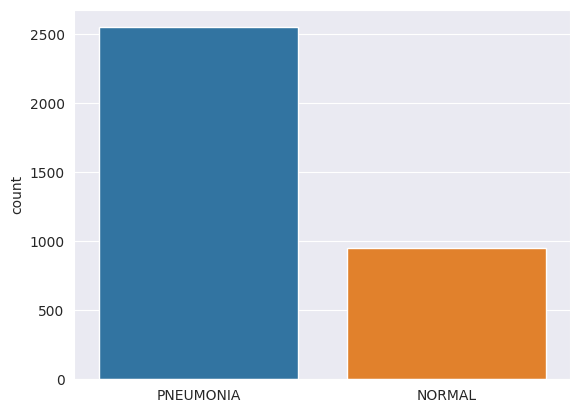

In [24]:
l = []
for i in train:
    if(i[1] == 0):
        l.append('PNEUMONIA') #PNEUMONIA
    else:
        l.append('NORMAL') #NORMAL

sns.set_style('darkgrid')
sns.countplot(x=l)     

The data seems imbalanced . To increase the no. of training examples, we will use data augmentation

Previewing the images of both the classes

Text(0.5, 1.0, 'NORMAL')

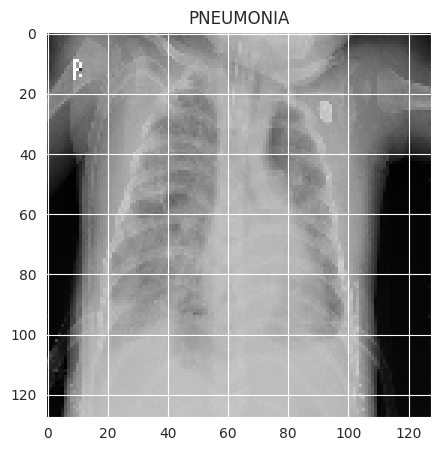

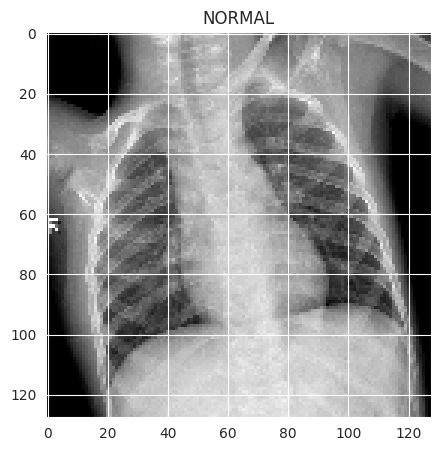

In [25]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(LABEL_NAMES[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(LABEL_NAMES[train[-1][1]])

In [26]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [27]:
x_train = np.array(x_train) 
x_val = np.array(x_val)
x_test = np.array(x_test) 

In [28]:
def resize_data(x, y, image_size):
    x_resized = np.array(x).reshape(-1, image_size, image_size, 1)
    y_resized = np.array(y)
    return x_resized, y_resized


In [29]:
# resize data for deep learning 
x_train, y_train = resize_data(x_train, y_train, IMAGE_SIZE)
x_val, y_val = resize_data(x_val, y_val, IMAGE_SIZE)
x_test, y_test = resize_data(x_test, y_test, IMAGE_SIZE)

In [30]:
def convert1chTo3ch(x):
    x3ch = np.zeros((x.shape[0], x.shape[1], x.shape[2], 3))
    x3ch[:,:,:,0] = x.squeeze()
    x3ch[:,:,:,1] = x.squeeze()
    x3ch[:,:,:,2] = x.squeeze()
    return x3ch.astype(np.uint8)

In [31]:
xVal3ch = convert1chTo3ch(x_val)
xTest3ch = convert1chTo3ch(x_test)
xTrain3ch = convert1chTo3ch(x_train)
xVal3ch.shape,xTrain3ch.shape,xTest3ch.shape

((1160, 128, 128, 3), (3498, 128, 128, 3), (1156, 128, 128, 3))

In [32]:
# dealing with class imbalance
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                    
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights


{0: 0.6861514319340918, 1: 1.8429926238145415}

Data Augmentation
To prevent overfitting and handling the imbalance in dataset.
For the data augmentation, according to the article provided , I choose to:

*   Randomly rescale images by 1.0/255 
*   Randomly shear images by 0.2
*   Randomly shift images horizontally by 0.2 of the width
*   Randomly shift images vertically by 0.2 of the height
*   Randomly rotate images by degree 30
*   Randomly flip images horizontally 
*   Randomly zoom images by 0.2

In [33]:
img_augmentation = ImageDataGenerator(
        rotation_range = 30,  # randomly rotate images in the range 
        zoom_range = 0.2, # Randomly zoom image 
        shear_range=0.2,# Randomly shear image 
        width_shift_range=0.2,  # randomly shift images horizontally 
        height_shift_range=0.2,  # randomly shift images vertically
        horizontal_flip = True  # randomly flip images
        )

In [34]:
print("x_train : " , xTrain3ch.shape, ", range: [" ,np.min(xTrain3ch)," ",np.max(xTrain3ch),"]")
print("y_train : " , y_train.shape, ", values: ",np.unique(y_train))
print("**************************")
print("x_test : " , xTest3ch.shape,", range: [" ,np.min(xTest3ch)," ",np.max(xTest3ch),"]")
print("y_test : " , y_test.shape,", values: ",np.unique(y_test))
print("**************************")
print("x_val : " , xVal3ch.shape, ", range: [" ,np.min(xVal3ch)," ",np.max(xVal3ch),"]")
print("y_val : " , y_val.shape,", values: ",np.unique(y_val))

x_train :  (3498, 128, 128, 3) , range: [ 0   255 ]
y_train :  (3498,) , values:  [0 1]
**************************
x_test :  (1156, 128, 128, 3) , range: [ 0   255 ]
y_test :  (1156,) , values:  [0 1]
**************************
x_val :  (1160, 128, 128, 3) , range: [ 0   255 ]
y_val :  (1160,) , values:  [0 1]


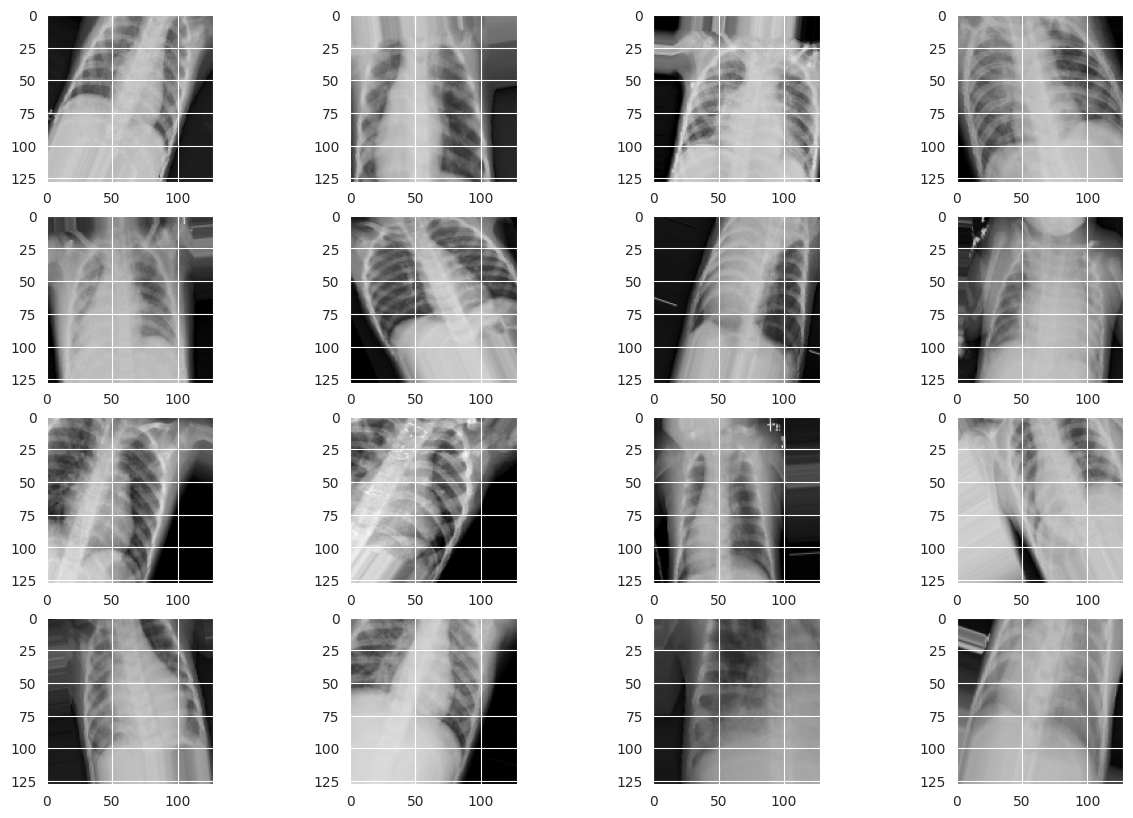

In [35]:
train_generator = img_augmentation.flow(xTrain3ch, batch_size=1)
rows = 4
columns = 4
fig, axes = plt.subplots(rows,columns)
for r in range(rows):
    for c in range(columns):
        image_batch = train_generator.next().astype("uint8") # astype(uint8) added to show 3 channel images
        image = image_batch[0]
        axes[r,c].imshow(image,cmap=plt.get_cmap("gray"))
fig.set_size_inches(15,10)

In [36]:
img_input = tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE,3))
base_model = EfficientNetB2(include_top=False,  weights="imagenet", input_tensor=img_input)

# Freeze the pretrained weights
base_model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
x = layers.Dense(128, activation="relu", name="dense_1")(x)
x = layers.Dropout(0.3, name="dropout_1")(x)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
x = layers.Dropout(0.2, name="dropout_2")(x)

output = layers.Dense(1, activation="sigmoid", name="pred")(x)

# Compile
model = keras.Model(inputs = img_input, outputs =output , name="EfficientNet")
optimizer = keras.optimizers.Adam(learning_rate=5e-5)
model.compile(
    optimizer=optimizer,loss= keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
    )

31790344/31790344 [==============================] - 1s 0us/step


In [37]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy')

In [38]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


In [39]:
epochs = 29 
history = model.fit(img_augmentation.flow(xTrain3ch,y_train, batch_size = 128),
                    epochs=epochs,
                    validation_data=(xVal3ch, y_val),
                    class_weight=class_weights,callbacks = [learning_rate_reduction])
                    



Epoch 1/29
28/28 [==============================] - 35s 643ms/step - loss: 0.6641 - accuracy: 0.5700 - val_loss: 0.5953 - val_accuracy: 0.8017 - lr: 5.0000e-05
Epoch 2/29
28/28 [==============================] - 17s 607ms/step - loss: 0.5850 - accuracy: 0.6847 - val_loss: 0.5234 - val_accuracy: 0.8319 - lr: 5.0000e-05
Epoch 3/29
28/28 [==============================] - 16s 579ms/step - loss: 0.5223 - accuracy: 0.7690 - val_loss: 0.4578 - val_accuracy: 0.8474 - lr: 5.0000e-05
Epoch 4/29
28/28 [==============================] - 16s 576ms/step - loss: 0.4693 - accuracy: 0.8027 - val_loss: 0.4180 - val_accuracy: 0.8500 - lr: 5.0000e-05
Epoch 5/29
28/28 [==============================] - 17s 595ms/step - loss: 0.4275 - accuracy: 0.8122 - val_loss: 0.3908 - val_accuracy: 0.8457 - lr: 5.0000e-05
Epoch 6/29
28/28 [==============================] - 16s 585ms/step - loss: 0.3979 - accuracy: 0.8339 - val_loss: 0.3596 - val_accuracy: 0.8578 - lr: 5.0000e-05
Epoch 7/29
28/28 [======================

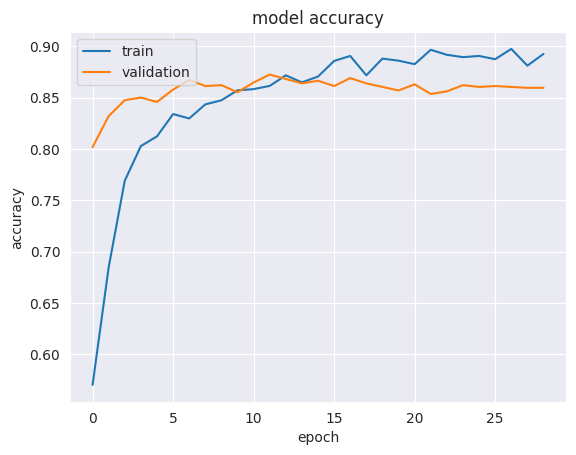

In [40]:
plot_hist(history)

In [41]:
base_model.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(5e-6),  # Low learning rate
    loss= keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()],
)


epochs = 15
hist = model.fit(img_augmentation.flow(xTrain3ch,y_train, batch_size = 128),
                    epochs=epochs,
                    validation_data=(xVal3ch, y_val),
                    class_weight=class_weights,
                 )

Epoch 1/15
28/28 [==============================] - 37s 776ms/step - loss: 0.6083 - binary_accuracy: 0.6584 - val_loss: 0.3149 - val_binary_accuracy: 0.8707
Epoch 2/15
28/28 [==============================] - 20s 704ms/step - loss: 0.5683 - binary_accuracy: 0.7001 - val_loss: 0.2963 - val_binary_accuracy: 0.8802
Epoch 3/15
28/28 [==============================] - 21s 736ms/step - loss: 0.5343 - binary_accuracy: 0.7333 - val_loss: 0.2951 - val_binary_accuracy: 0.8793
Epoch 4/15
28/28 [==============================] - 20s 702ms/step - loss: 0.5006 - binary_accuracy: 0.7627 - val_loss: 0.2959 - val_binary_accuracy: 0.8836
Epoch 5/15
28/28 [==============================] - 21s 746ms/step - loss: 0.4668 - binary_accuracy: 0.7936 - val_loss: 0.3017 - val_binary_accuracy: 0.8897
Epoch 6/15
28/28 [==============================] - 22s 763ms/step - loss: 0.4418 - binary_accuracy: 0.8113 - val_loss: 0.3112 - val_binary_accuracy: 0.8888
Epoch 7/15
28/28 [==============================] - 20s 73

In [119]:
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [42]:
print(hist.params)

# check the keys of history object
print(hist.history.keys())


{'verbose': 1, 'epochs': 15, 'steps': 28}
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


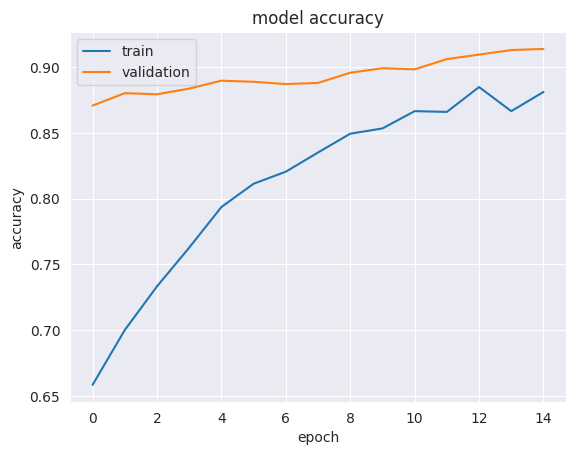

In [43]:
plt.plot(hist.history["binary_accuracy"])
plt.plot(hist.history["val_binary_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()


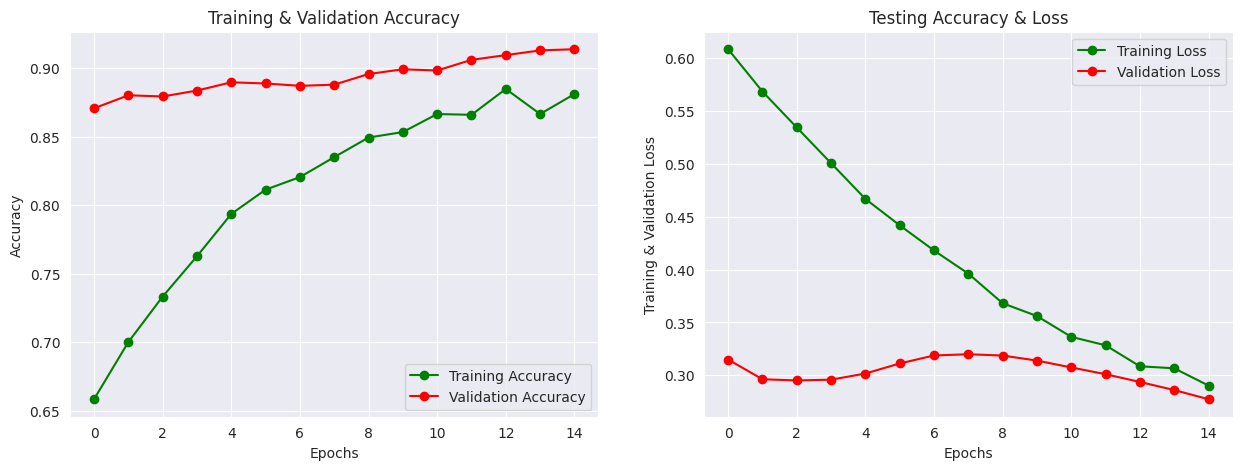

In [44]:
epochs = [i for i in range(epochs)]
fig , ax = plt.subplots(1,2)
train_acc = hist.history['binary_accuracy']
train_loss = hist.history['loss']
val_acc = hist.history['val_binary_accuracy']
val_loss = hist.history['val_loss']
fig.set_size_inches(15,5)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [45]:
predictions = model.predict(xTest3ch)
predictions = predictions.reshape(1,-1)[0]
predictions =np.where(predictions < 0.5, 0, 1)

37/37 [==============================] - 4s 45ms/step


In [46]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.95      0.93      0.94       840
   Normal (Class 1)       0.82      0.86      0.84       316

           accuracy                           0.91      1156
          macro avg       0.89      0.90      0.89      1156
       weighted avg       0.91      0.91      0.91      1156



<Axes: >

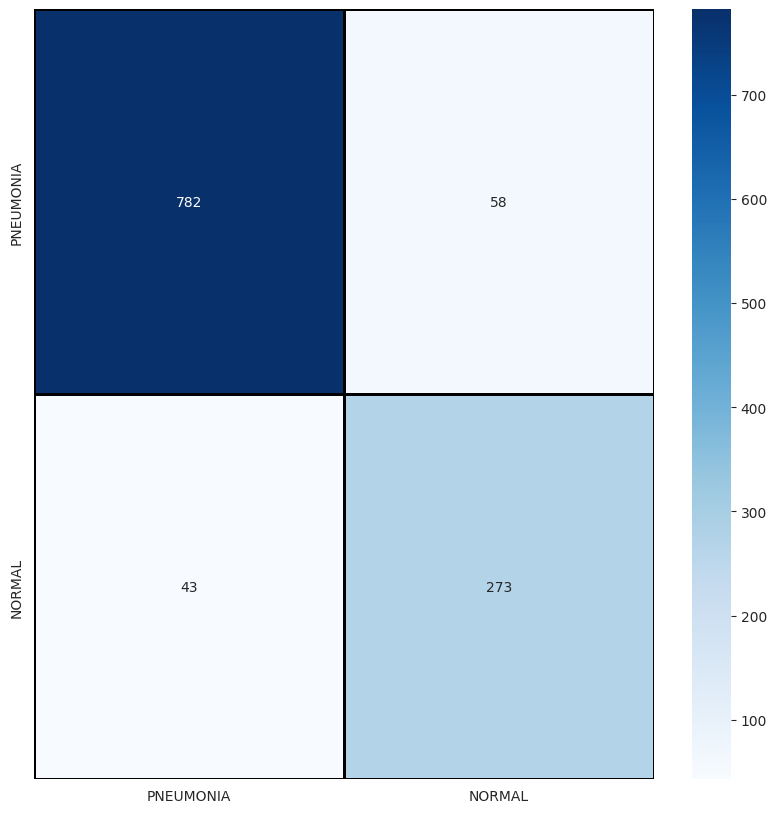

In [47]:
cm = confusion_matrix(y_test,predictions)

cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = LABEL_NAMES,yticklabels = LABEL_NAMES)

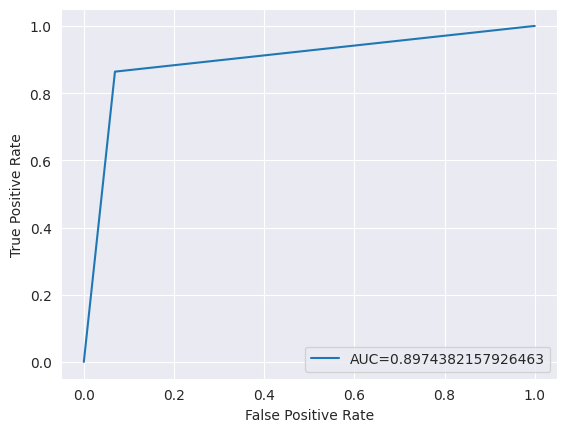

In [49]:
fpr, tpr, _ = roc_curve(y_test,  predictions)
auc = roc_auc_score(y_test, predictions)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [68]:
model.evaluate


<bound method Model.evaluate of <keras.engine.functional.Functional object at 0x7f9cd8028c70>>

In [50]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

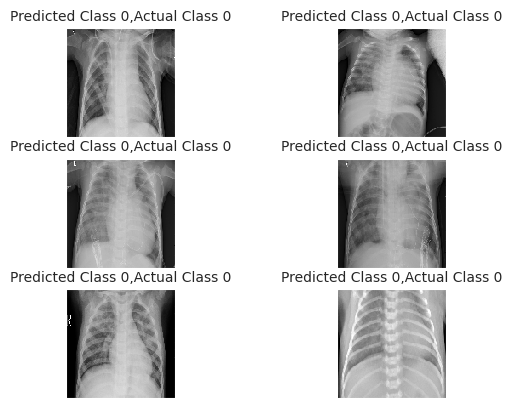

In [59]:
#Some of the Correctly Predicted Classes
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c], cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]), fontsize=10)
    i += 1

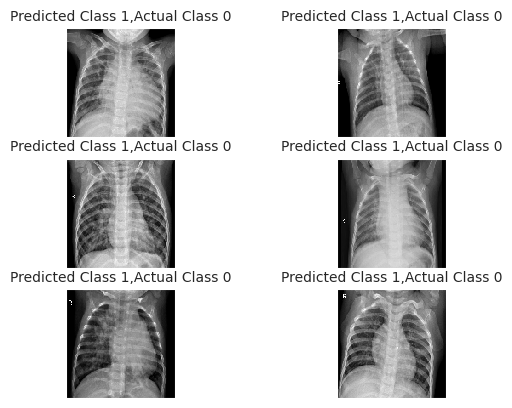

In [58]:
#Some of the Incorrectly Predicted Classes
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c], cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]), fontsize=10)
    i += 1